# Parte introduttiva

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet

c:\Users\giuli\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cd

C:\Users\giuli


In [3]:
# Impostare path della directory
%cd C:/Users/giuli/OneDrive/Documenti/Lab ML/templatepw

C:\Users\giuli\OneDrive\Documenti\Lab ML\templatepw


In [10]:
# Verificare i file dentro alla directory
!ls 

"ls" non � riconosciuto come comando interno o esterno,
 un programma eseguibile o un file batch.


In [4]:
# Importo dataset
data = pd.read_excel('dati.xlsx', 
                     index_col = 'Calendario',
                     parse_dates = True
                     )
data

,Quantita,Tipologia
Calendario,,
2021-05-05,2.00,Spine
2021-05-21,3.25,Spine
2021-05-25,228.00,Spine
2021-05-26,181.80,Spine
2021-05-27,256.00,Spine
...,...,...
2022-11-05,128.18,Cocktail
2022-11-19,58.12,Cocktail
2022-11-20,16.00,Cocktail


In [5]:
# Creo dataset con solo i dati relativi ai burger
df_burger = data[data['Tipologia'] == 'Burger']
df_burger

,Quantita,Tipologia
Calendario,,
2021-05-08,13.00,Burger
2021-05-21,3.00,Burger
2021-05-25,58.00,Burger
2021-05-26,62.00,Burger
2021-05-27,55.00,Burger
...,...,...
2022-11-05,65.09,Burger
2022-11-19,62.20,Burger
2022-11-20,46.24,Burger


In [13]:
df_burger.describe()

,Quantita
count,520.000000
mean,56.594115
std,26.094139
min,1.000000
25%,38.000000
50%,52.000000
75%,71.250000
max,144.970000


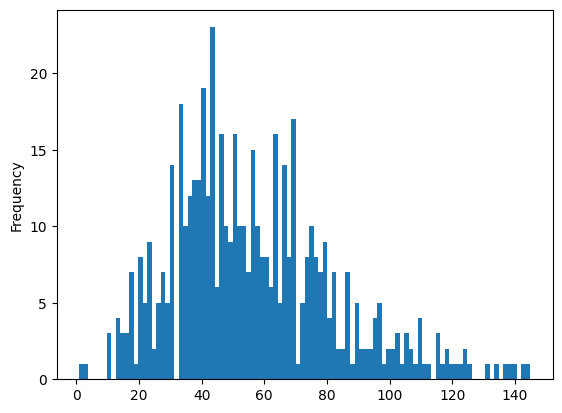

In [14]:
df_burger['Quantita'].plot(kind='hist', bins=100);

In [6]:
df_burger.sort_values(by= 'Quantita', ascending = True)
# anche qui (come a lezione) ci sono degli outlier -> da capire se eliminare dati con quantità troppo basse o troppo alte

,Quantita,Tipologia
Calendario,,
2022-01-10,1.00,Burger
2021-05-21,3.00,Burger
2021-11-15,11.00,Burger
2021-11-10,11.00,Burger
2021-10-11,11.00,Burger
...,...,...
2022-07-08,137.00,Burger
2022-09-18,138.98,Burger
2022-08-19,139.98,Burger


In [7]:
# Tolgo colonna della tipologia che non serve più
df_burger = df_burger.drop('Tipologia', axis = 1)
df_burger

,Quantita
Calendario,
2021-05-08,13.00
2021-05-21,3.00
2021-05-25,58.00
2021-05-26,62.00
2021-05-27,55.00
...,...
2022-11-05,65.09
2022-11-19,62.20
2022-11-20,46.24


In [8]:
# Tolgo outlier dati a sinistra e destra
df_burger = df_burger[(df_burger.index >= '2021-05-25') & (df_burger.index <= '2022-11-05')]
len(df_burger)
df_burger

,Quantita
Calendario,
2021-05-25,58.00
2021-05-26,62.00
2021-05-27,55.00
2021-05-28,74.00
2021-05-29,64.00
...,...
2022-11-01,23.98
2022-11-02,23.00
2022-11-03,26.00


<AxesSubplot: xlabel='Calendario'>

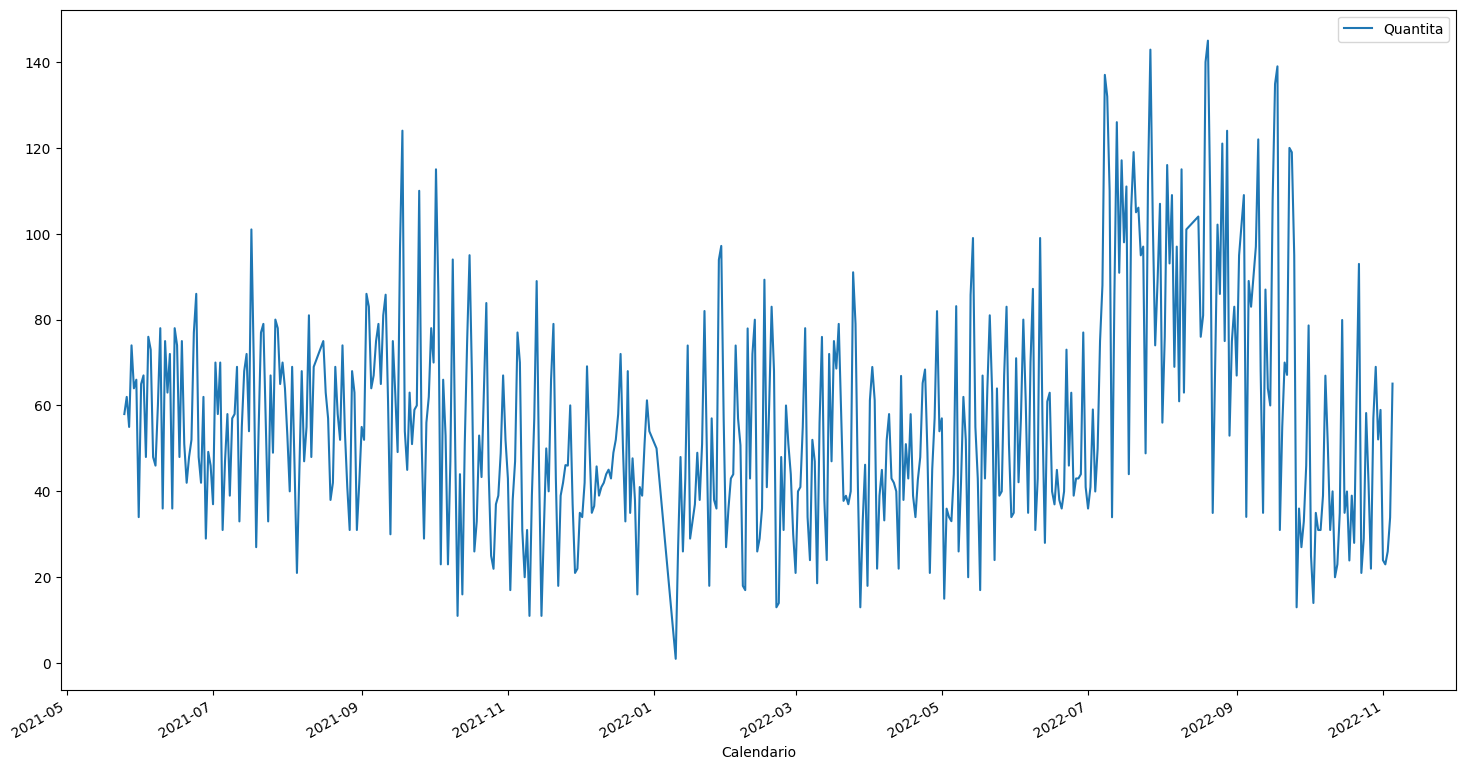

In [9]:
from matplotlib.figure import figaspect
# Grafico con Matplotlib
ax = plt.gca()
df_burger.plot(figsize=(18,10), ax=ax)

In [10]:
import plotly.graph_objects as go

In [11]:
from tables import index
# Grafico con Plotly
fig = go.Figure()

fig.add_trace(go.Scatter(x = df_burger.index, 
                         y = df_burger['Quantita'],
                         mode = "lines",
                         name = "Burger",
                         line_color='#0000FF',
                         ))
# adjust layout
fig.update_layout(title = "Burger venduti",
                  xaxis_title = "Date",
                  yaxis_title = "Quantità",
                  width = 1000,
                  height = 700,
                  )

# zoomming
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=2, label="3m", step="month", stepmode="backward"),
            dict(count=3, label="5m", step="month", stepmode="backward"),
            dict(step="all")
        ])
    )
)

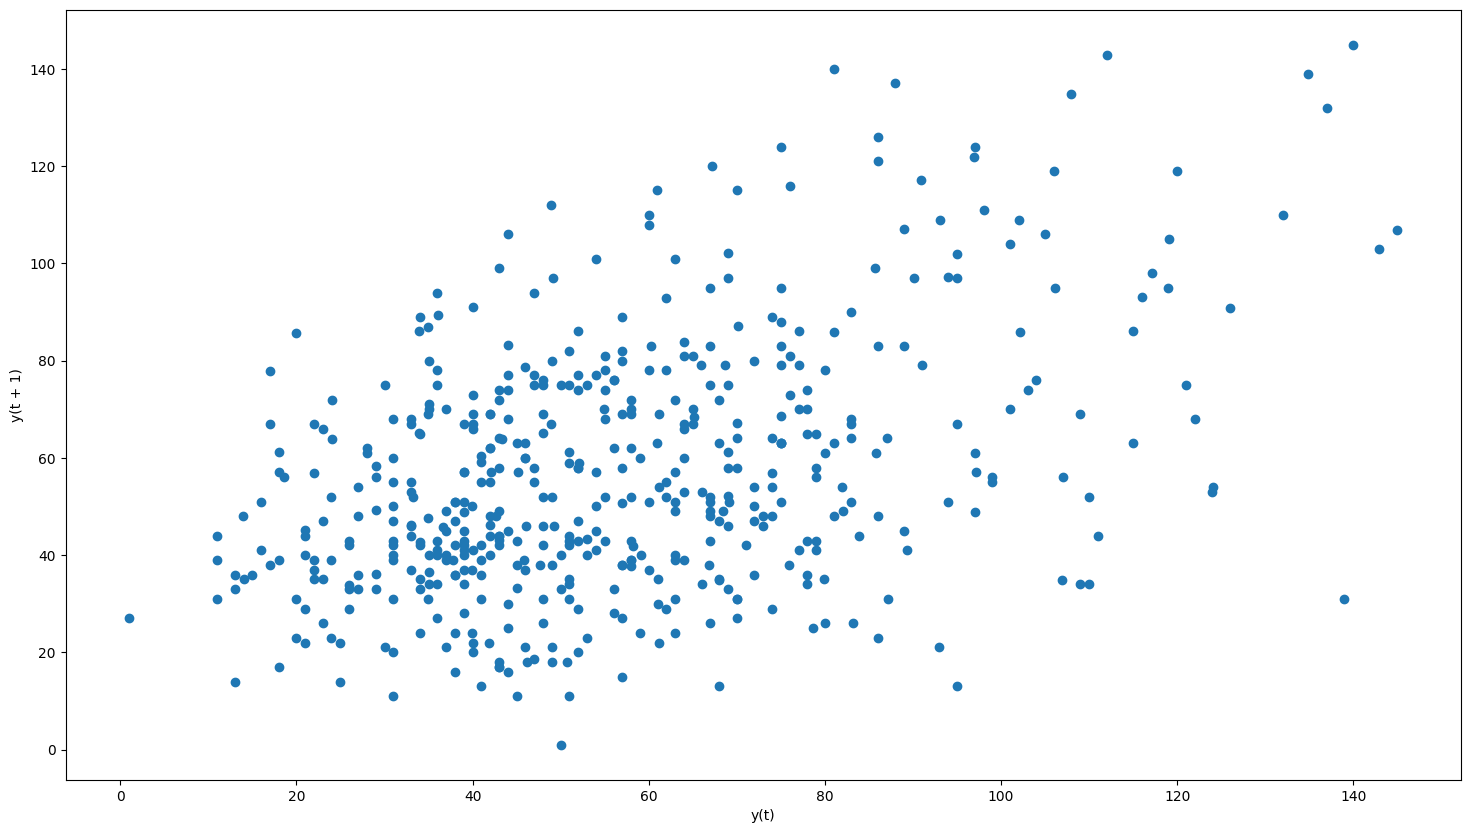

In [12]:
# Analizzare correlazione
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot

plt.figure(figsize=(18,10))
lag_plot(df_burger['Quantita']);

# Prophet

## Parte introduttiva

In [13]:
# Resetto indice per poter riportare la data come colonna e poter creare la colonna ds per Prophet
df_burger = df_burger.reset_index()
df_burger

,Calendario,Quantita
0,2021-05-25,58.00
1,2021-05-26,62.00
2,2021-05-27,55.00
3,2021-05-28,74.00
4,2021-05-29,64.00
...,...,...
509,2022-11-01,23.98
510,2022-11-02,23.00
511,2022-11-03,26.00
512,2022-11-04,33.93


In [14]:
# Credo colonne ds e y 
df_burger.columns = ['ds', 'y']
df_burger

,ds,y
0,2021-05-25,58.00
1,2021-05-26,62.00
2,2021-05-27,55.00
3,2021-05-28,74.00
4,2021-05-29,64.00
...,...,...
509,2022-11-01,23.98
510,2022-11-02,23.00
511,2022-11-03,26.00
512,2022-11-04,33.93


In [15]:
# Creo il modello
m = Prophet(daily_seasonality  = False,
            weekly_seasonality = True,
            yearly_seasonality = True,
            seasonality_mode   = 'additive',
            interval_width=0.95,
            )
m.add_country_holidays(country_name='IT')
model = m.fit(df_burger)

17:49:50 - cmdstanpy - INFO - Chain [1] start processing
17:49:51 - cmdstanpy - INFO - Chain [1] done processing


In [26]:
model.seasonalities

OrderedDict([('yearly',
              {'period': 365.25,
               'fourier_order': 10,
               'prior_scale': 10.0,
               'mode': 'additive',
               'condition_name': None}),
             ('weekly',
              {'period': 7,
               'fourier_order': 3,
               'prior_scale': 10.0,
               'mode': 'additive',
               'condition_name': None})])

In [16]:
# Faccio previsione
#future = model.make_future_dataframe(periods=60, freq='D')
future = model.make_future_dataframe(periods=120)

In [17]:
# Controllo che tornino le dimensioni
print(len(df_burger))
print(len(future))

514
634


In [18]:
# Faccio forecast
forecast = model.predict(future)
forecast
# di tutte questa variabili mi servono solo yhat, yhat_lower,	yhat_upper

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Assunzione della Vergine,Assunzione della Vergine_lower,Assunzione della Vergine_upper,Capodanno,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-05-25,46.898955,11.014251,80.815306,46.898955,46.898955,0.0,0.0,0.0,0.0,...,-4.550419,-4.550419,-4.550419,3.485037,3.485037,3.485037,0.0,0.0,0.0,45.833573
1,2021-05-26,46.927683,18.496199,86.447231,46.927683,46.927683,0.0,0.0,0.0,0.0,...,0.815537,0.815537,0.815537,4.566980,4.566980,4.566980,0.0,0.0,0.0,52.310200
2,2021-05-27,46.956412,10.764660,82.006335,46.956412,46.956412,0.0,0.0,0.0,0.0,...,-6.831095,-6.831095,-6.831095,5.575281,5.575281,5.575281,0.0,0.0,0.0,45.700597
3,2021-05-28,46.985140,30.190432,99.765987,46.985140,46.985140,0.0,0.0,0.0,0.0,...,10.115302,10.115302,10.115302,6.489560,6.489560,6.489560,0.0,0.0,0.0,63.590002
4,2021-05-29,47.013869,41.795385,112.802115,47.013869,47.013869,0.0,0.0,0.0,0.0,...,21.380833,21.380833,21.380833,7.291158,7.291158,7.291158,0.0,0.0,0.0,75.685859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
629,2023-03-01,64.473671,15.164551,87.440241,64.429793,64.514026,0.0,0.0,0.0,0.0,...,0.815537,0.815537,0.815537,-13.529783,-13.529783,-13.529783,0.0,0.0,0.0,51.759425
630,2023-03-02,64.500143,7.624493,77.820170,64.455718,64.541063,0.0,0.0,0.0,0.0,...,-6.831095,-6.831095,-6.831095,-13.275489,-13.275489,-13.275489,0.0,0.0,0.0,44.393559
631,2023-03-03,64.526615,25.571037,95.994914,64.481651,64.567766,0.0,0.0,0.0,0.0,...,10.115302,10.115302,10.115302,-12.868735,-12.868735,-12.868735,0.0,0.0,0.0,61.773182
632,2023-03-04,64.553087,38.680440,108.184278,64.507593,64.594522,0.0,0.0,0.0,0.0,...,21.380833,21.380833,21.380833,-12.319409,-12.319409,-12.319409,0.0,0.0,0.0,73.614511


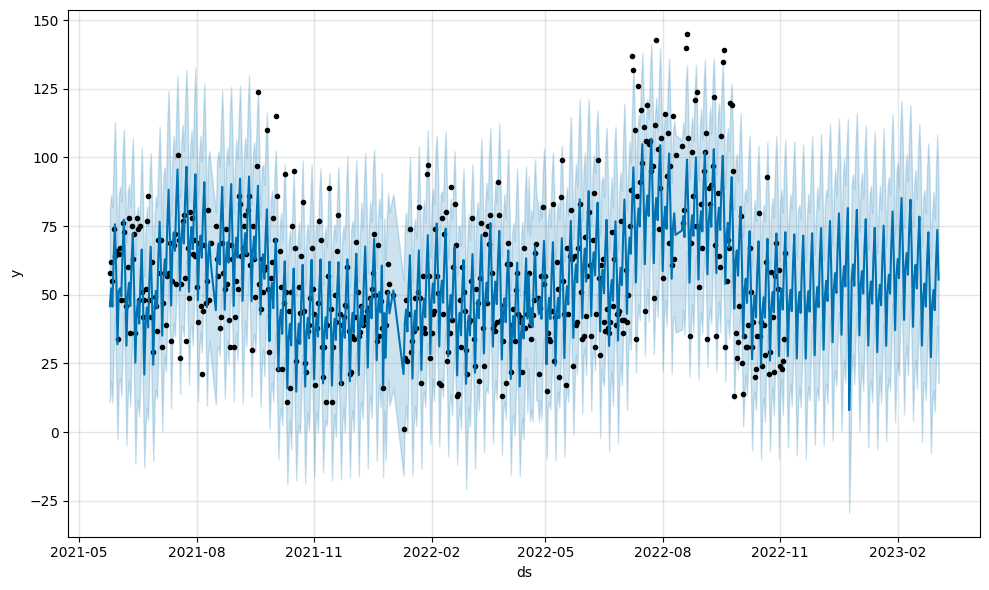

In [19]:
model.plot(forecast);

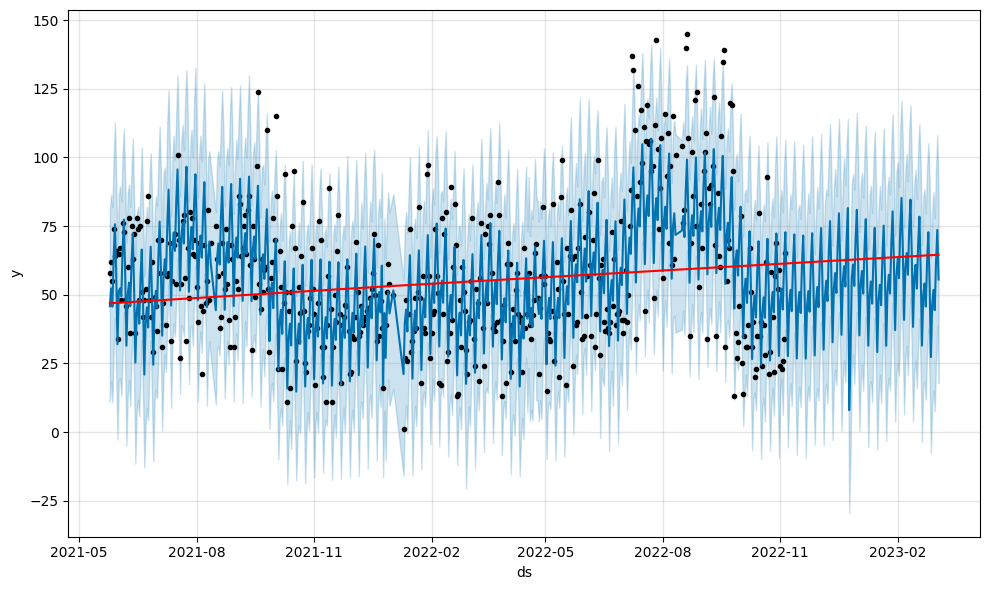

In [20]:
# Guardo i change points
from prophet.plot import add_changepoints_to_plot

plot = model.plot(forecast)
a = add_changepoints_to_plot(plot.gca(), model, forecast)

In [21]:
# Grafico su plotly
from prophet.plot import plot_plotly
from datetime import datetime

fig = plot_plotly(model, forecast)

fig.update_layout(yaxis_title = 'Quantità',
                  xaxis_title = 'Date',
                  title = 'Vendita Burger'
)

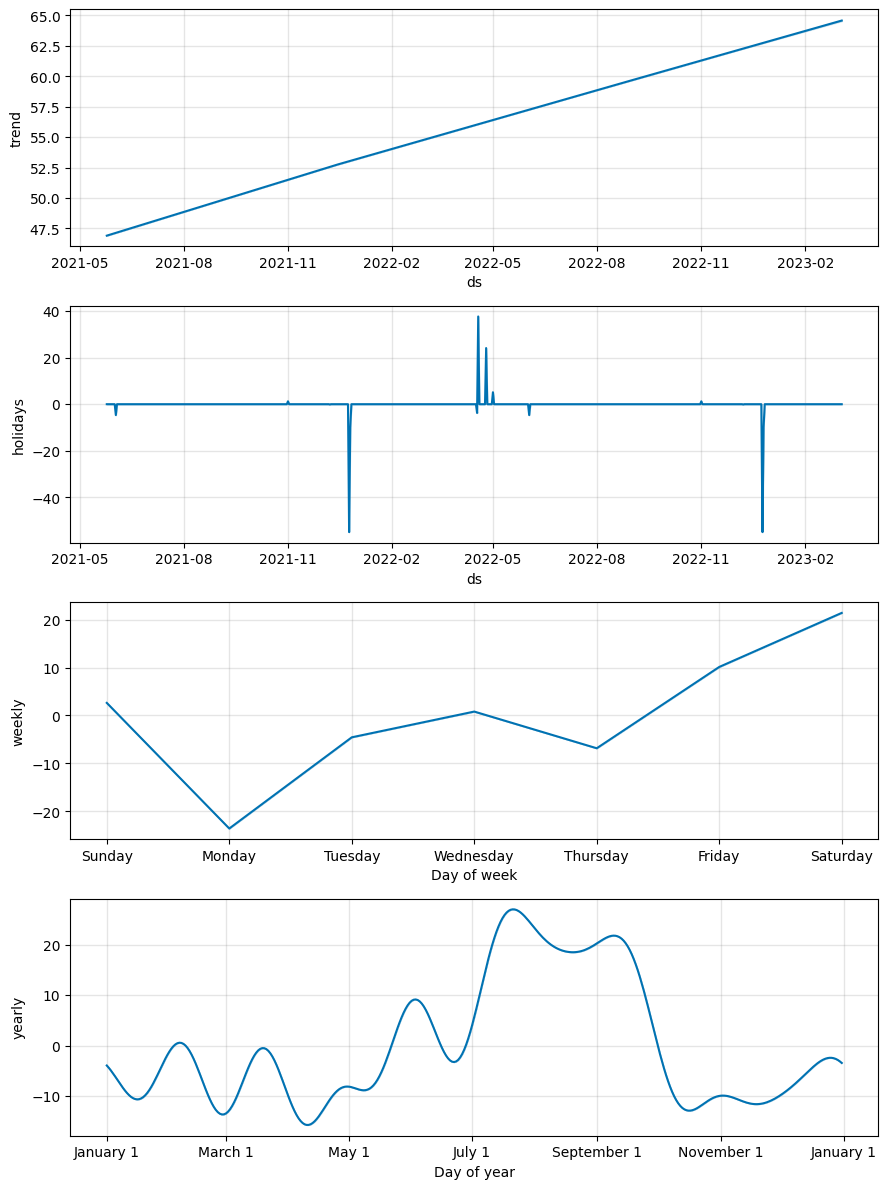

In [22]:
# Stampo componenti
model.plot_components(forecast);

## Indici di errore

In [23]:
# Unisco dataset
df_merge = pd.merge(df_burger, forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on = 'ds')

# Tengo solo le variabili che mi interessano
df_merge = df_merge[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'y']]
df_merge.tail()

,ds,yhat,yhat_lower,yhat_upper,y
509,2022-11-01,48.058367,15.291867,83.819191,23.98
510,2022-11-02,52.251604,19.409863,88.191638,23.00
511,2022-11-03,44.628815,6.254436,80.015222,26.00
512,2022-11-04,61.563286,27.223811,96.755191,33.93
513,2022-11-05,72.784600,37.492547,106.401694,65.09


In [24]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

# Calcolo gl indici per vedere errori
y_true = df_merge['y'].values
y_pred = df_merge['yhat'].values

mae = mean_absolute_error(y_true, y_pred)
print('MAE: ', mae)

mse = mean_squared_error(y_true, y_pred)
print('MSE: ', mse)

mape = mean_absolute_percentage_error(y_true, y_pred)
print('MAPE: ', mape)

ModuleNotFoundError: No module named 'sklearn'

## Cross Validation

In [25]:
# Cross validation
from prophet.diagnostics import cross_validation

df_cv = cross_validation(model,
                         horizon = "120 days",
                         period = "10 days",
                         initial = "360 days")

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/5 [00:00<?, ?it/s]17:52:24 - cmdstanpy - INFO - Chain [1] start processing
17:52:24 - cmdstanpy - INFO - Chain [1] done processing
 20%|██        | 1/5 [00:00<00:01,  2.43it/s]17:52:25 - cmdstanpy - INFO - Chain [1] start processing
17:52:25 - cmdstanpy - INFO - Chain [1] done processing
 40%|████      | 2/5 [00:00<00:01,  2.66it/s]17:52:25 - cmdstanpy - INFO - Chain [1] start processing
17:52:25 - cmdstanpy - INFO - Chain [1] done processing
 60%|██████    | 3/5 [00:01<00:00,  2.49it/s]17:52:25 - cmdstanpy - INFO - Chain [1] start processing
17:52:26 - cmdstanpy - INFO - Chain [1] done processing
 80%|████████  | 4/5 [00:01<00:00,  2.63it/s]17:52:26 - cmdstanpy - INFO - Chain [1] start processing
17:52:26 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 5/5 [00:01<00:00,  2.59it/s]


In [26]:
from prophet.diagnostics import performance_metrics

df_performance = performance_metrics(df_cv)
df_performance.head(10)

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,12 days,841.561957,29.009687,21.942979,0.326418,0.346233,0.333618,0.703448
1,13 days,828.694419,28.787053,21.763524,0.321423,0.342377,0.330300,0.713793
2,14 days,850.176317,29.157783,22.357235,0.324320,0.331682,0.335817,0.672414
3,15 days,921.305236,30.353010,22.863946,0.320760,0.321366,0.337898,0.662069
4,16 days,925.507921,30.422162,22.891208,0.315791,0.319720,0.338673,0.644828
5,17 days,947.845183,30.787094,23.382826,0.326593,0.319720,0.345009,0.627586
6,18 days,987.880559,31.430567,24.288174,0.334456,0.334780,0.355637,0.634483
7,19 days,1166.665388,34.156484,26.769190,0.357914,0.345518,0.387047,0.586207
8,20 days,1282.002732,35.805066,28.028622,0.366509,0.370168,0.397765,0.555172
9,21 days,1293.688017,35.967875,28.157892,0.360427,0.353573,0.394296,0.565517


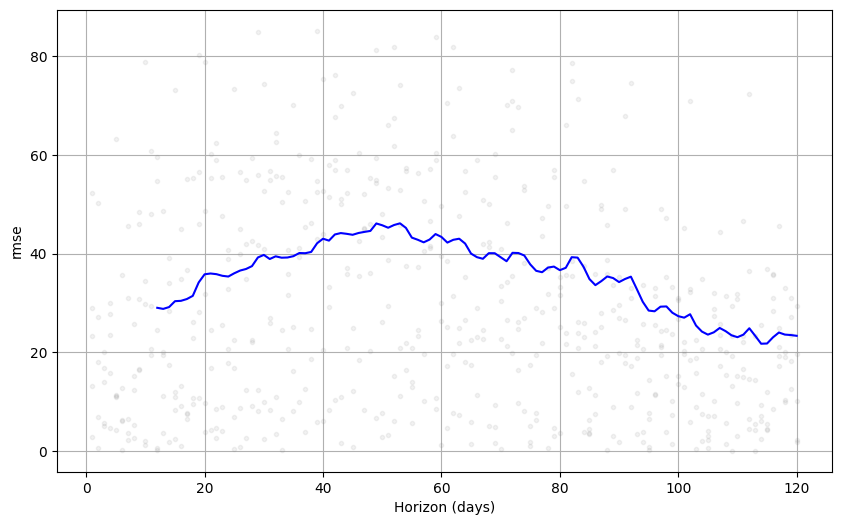

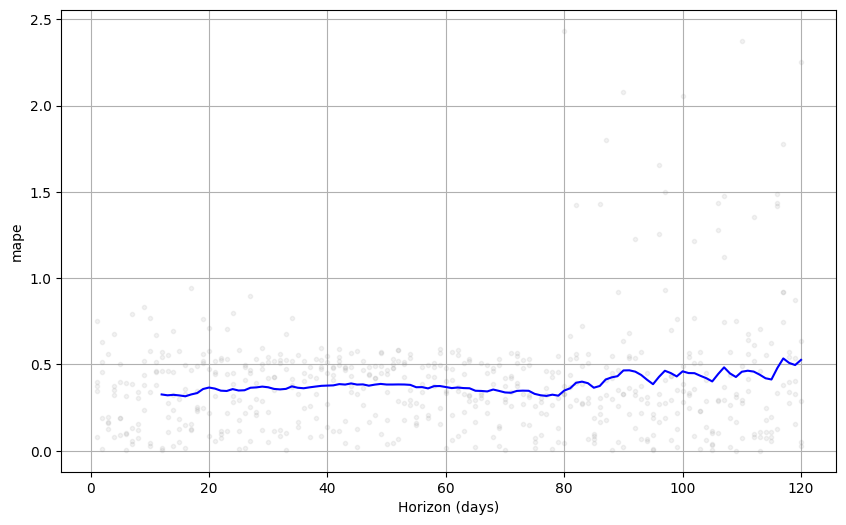

In [27]:
from prophet.plot import plot_cross_validation_metric

fig = plot_cross_validation_metric(df_cv, metric='rmse')

fig = plot_cross_validation_metric(df_cv, metric='mape')

In [28]:
df_performance.mean()

horizon     66 days 00:00:00
mse              1309.086436
rmse               35.478482
mae                29.315162
mape                0.388072
mdape               0.363094
smape               0.415607
coverage            0.547137
dtype: object

In [64]:
# GridSearch
import itertools

param_grid = { 'changepoint_prior_scale':[0.001, 0.01, 0.1, 0.05],
              'seasonality_prior_scale':[0.01, 0.1, 1.0, 10.0], }

# Genero tutte le combinazioni dei parametri
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
mape = []  # Store the RMSEs for each params here

In [65]:
for params in all_params:
    model = Prophet(**params).fit(df_burger)  # Fit model with given params
    df_cv = cross_validation(model, 
                             horizon = "120 days",
                         period = "10 days",
                         initial = "360 days" ,
                             )
    
    df_performance = performance_metrics(df_cv, rolling_window=1)
    mape.append(df_performance['mape'].values[0])

tuning_results = pd.DataFrame(all_params)
tuning_results['mape'] = mape
print(tuning_results)

18:06:01 - cmdstanpy - INFO - Chain [1] start processing
18:06:01 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/5 [00:00<?, ?it/s]18:06:01 - cmdstanpy - INFO - Chain [1] start processing
18:06:01 - cmdstanpy - INFO - Chain [1] done processing
 20%|██        | 1/5 [00:00<00:01,  2.95it/s]18:06:02 - cmdstanpy - INFO - Chain [1] start processing
18:06:02 - cmdstanpy - INFO - Chain [1] done processing
18:06:02 - cmdstanpy - ERROR - Chain [1] error: error during processing Unknown error
Optimization terminated abnormally. Falling back to Newton.
18:06:02 - cmdstanpy - INFO - Chain [1] start processing
18:06:02 - cmdstanpy - INFO - Chain [1] done processing
 40%|████      | 2/5 [00:01<00:01,  1.68it/s]18:06:03 - cmdstanpy - INFO - Chain [1] start processing
18:06:03 - cmdstanpy - INFO - Chain [1] done processing
 60%|██████    | 3/5 [00:01<00:00,  2.12it/s]18:06:03 - cmdstanpy - INFO - Chain [1] start processing
18:06:03 - cmdstanpy - INFO - Chain [1] done processing
 80%

    changepoint_prior_scale  seasonality_prior_scale      mape
0                     0.001                     0.01  0.431232
1                     0.001                     0.10  0.433350
2                     0.001                     1.00  0.434087
3                     0.001                    10.00  0.434361
4                     0.010                     0.01  0.427824
5                     0.010                     0.10  0.431426
6                     0.010                     1.00  0.432603
7                     0.010                    10.00  0.431713
8                     0.100                     0.01  0.442422
9                     0.100                     0.10  0.419347
10                    0.100                     1.00  0.419420
11                    0.100                    10.00  0.419461
12                    0.050                     0.01  0.434390
13                    0.050                     0.10  0.422141
14                    0.050                     1.00  0

In [66]:
best_params = all_params[np.argmin(mape)]
print(best_params)

{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1}


In [67]:
'''
model_tuned = Prophet(seasonality_mode='additive', 
            interval_width=0.95,
            changepoint_prior_scale= 0.079,
                      seasonality_prior_scale= 0.109,) #mape 0.3949
'''

model_tuned = Prophet(changepoint_prior_scale= 0.1,
                      seasonality_prior_scale= 0.1,
                      seasonality_mode = 'additive',
                      interval_width = 0.95,
                      daily_seasonality  = False,
                      weekly_seasonality = True,
                      yearly_seasonality = True,
                     )
model_tuned.fit(df_burger)

18:07:16 - cmdstanpy - INFO - Chain [1] start processing
18:07:16 - cmdstanpy - INFO - Chain [1] done processing


In [68]:
df_cv_final = cross_validation(model_tuned,
                         horizon = "120 days",
                         period = "10 days",
                         initial = "360 days")

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/5 [00:00<?, ?it/s]18:07:17 - cmdstanpy - INFO - Chain [1] start processing
18:07:17 - cmdstanpy - INFO - Chain [1] done processing
 20%|██        | 1/5 [00:00<00:01,  3.13it/s]18:07:18 - cmdstanpy - INFO - Chain [1] start processing
18:07:18 - cmdstanpy - INFO - Chain [1] done processing
 40%|████      | 2/5 [00:00<00:01,  2.59it/s]18:07:18 - cmdstanpy - INFO - Chain [1] start processing
18:07:18 - cmdstanpy - INFO - Chain [1] done processing
 60%|██████    | 3/5 [00:01<00:00,  2.72it/s]18:07:18 - cmdstanpy - INFO - Chain [1] start processing
18:07:18 - cmdstanpy - INFO - Chain [1] done processing
 80%|████████  | 4/5 [00:01<00:00,  2.73it/s]18:07:19 - cmdstanpy - INFO - Chain [1] start processing
18:07:19 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 5/5 [00:01<00:00,  2.82it/s]


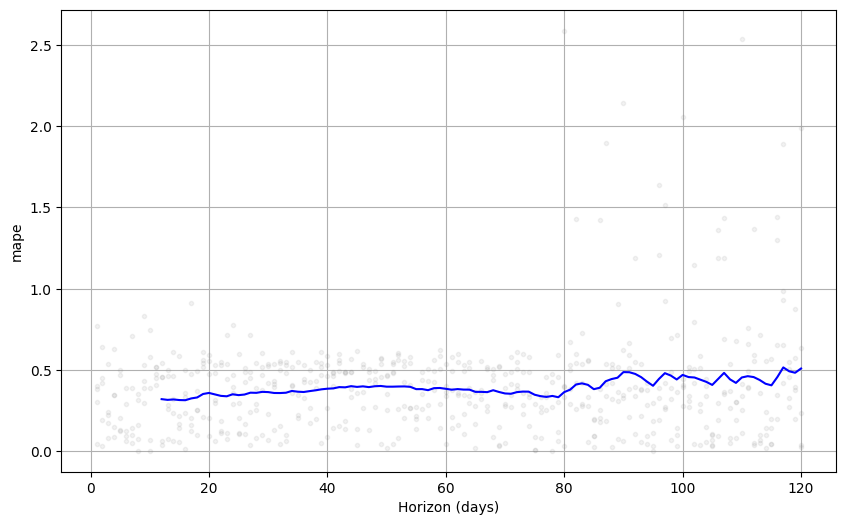

In [69]:
fig=plot_cross_validation_metric(df_cv_final,metric='mape')

In [70]:
fig = plot_plotly(model_tuned, forecast)

fig.update_layout(yaxis_title = 'Quantità',
                  xaxis_title = 'Date',
                  title = 'Vendita Burger'
)

In [56]:
# GridSearch
import itertools
x1=list(np.arange(0.079,0.082, 0.001))
x2=list(np.arange(0.08, 0.12, 0.01))

param_grid = { 'changepoint_prior_scale': x1,
              'seasonality_prior_scale':x2, }

# Genero tutte le combinazioni dei parametri
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
mape = []  # Store the RMSEs for each params here

### Indici di errore

In [71]:
performance_metrics(df_cv_final).mean()

horizon     66 days 00:00:00
mse              1387.694228
rmse               36.529268
mae                30.227368
mape                0.395081
mdape               0.378781
smape               0.430596
coverage            0.543515
dtype: object

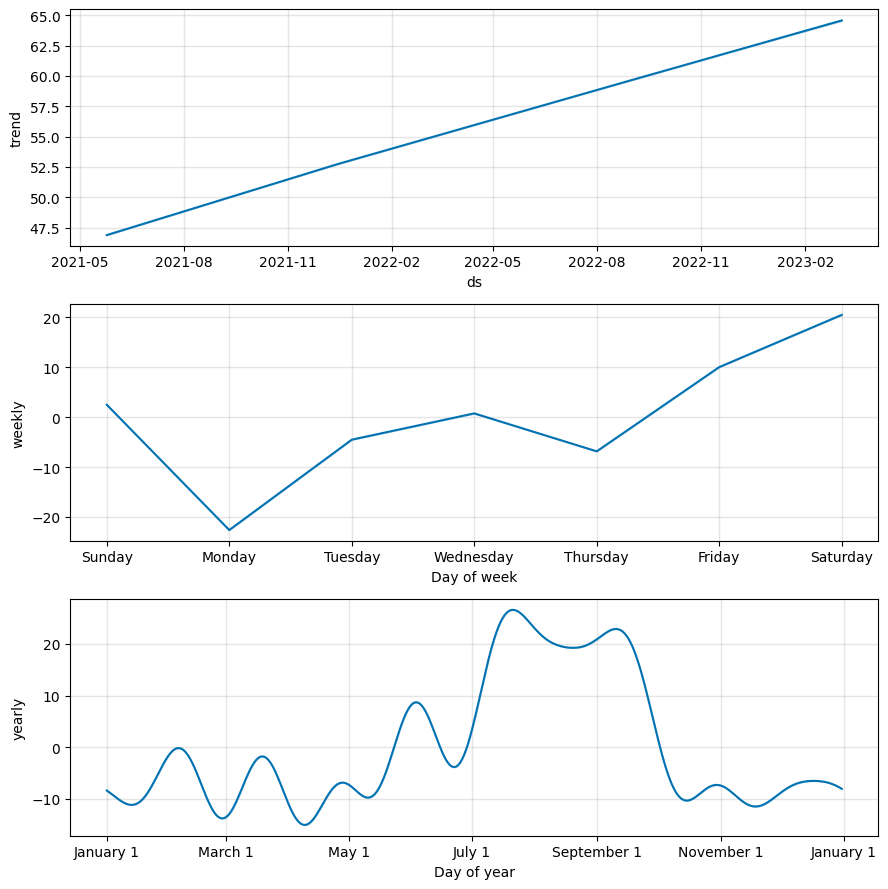

In [74]:
model_tuned.plot_components(forecast);

In [72]:
# Save model
import joblib

joblib.dump(model_tuned,'model_burger.pkl')

['model_burger.pkl']

## Multivariata

In [136]:
import datetime
import pandas as pd
import requests
import matplotlib as mpl
import matplotlib.pyplot as plt

import plotly.express as px

In [137]:
!pip install meteostat -q

In [138]:
cities = {'Forlì':[44.233334,12.050000]}
cities.values()

dict_values([[44.233334, 12.05]])

In [140]:
# Import Meteostat library and dependencies
from datetime import datetime
import matplotlib.pyplot as plt
from meteostat import Point, Daily

# Set time period
start = datetime(2021, 5, 25) 
end = datetime(2022, 12, 13) 	

cities = {'Forlì':[44.233334,12.050000]}


# Create Point for Vancouver, BC
city = Point(list(cities.values())[0][0],list(cities.values())[0][1], 20)

# Get daily data for 2021
data_time = Daily(city, start, end)
data_time = data_time.fetch()
data_time['city'] = list(cities.keys())[0]

data_time

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,city
time,,,,,,,,,,,
2021-05-25,18.5,13.4,23.0,0.0,NaN,240.0,17.7,NaN,1016.5,NaN,Forlì
2021-05-26,17.5,11.5,22.0,0.0,NaN,188.0,9.2,NaN,1017.5,NaN,Forlì
2021-05-27,19.7,13.0,26.0,0.0,NaN,211.0,7.3,NaN,1014.4,NaN,Forlì
2021-05-28,18.8,13.3,23.0,0.0,NaN,139.0,10.9,NaN,1017.7,NaN,Forlì
2021-05-29,19.4,14.0,27.0,1.1,NaN,102.0,8.6,NaN,1016.5,NaN,Forlì
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-09,5.9,5.0,7.0,6.1,NaN,290.0,8.1,NaN,1003.5,NaN,Forlì
2022-12-10,5.9,5.0,7.0,3.3,NaN,289.0,6.2,NaN,999.1,NaN,Forlì
2022-12-11,5.1,3.0,8.0,12.8,NaN,287.0,12.2,NaN,1001.3,NaN,Forlì


In [141]:
def printStats(dataframe):
  print("Rows     :", dataframe.shape[0])
  print("Columns  :", dataframe.shape[1])
  print("\n Features \n", dataframe.columns.to_list())
  print("\n Missing Values \n", dataframe.isnull().any())
  print("\n Unique Values \n", dataframe.nunique())
     

In [142]:
printStats(data_time)

Rows     : 568
Columns  : 11

 Features 
 ['tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres', 'tsun', 'city']

 Missing Values 
 tavg    False
tmin    False
tmax     True
prcp    False
snow     True
wdir     True
wspd     True
wpgt     True
pres     True
tsun     True
city    False
dtype: bool

 Unique Values 
 tavg    247
tmin    176
tmax     60
prcp     83
snow      0
wdir    242
wspd    120
wpgt      0
pres    234
tsun      0
city      1
dtype: int64


In [143]:
data_time['tmax']= data_time['tmax'].fillna(method = 'ffill')
data_time['wdir']= data_time['wdir'].fillna(method = 'ffill')
data_time['wspd']= data_time['wspd'].fillna(method = 'ffill')
data_time['pres']= data_time['pres'].fillna(method = 'ffill')

'''
ny_df_final = data_time.reset_index()[['timeStamp','demand','temp']].rename({'timeStamp':'ds','demand':'y','temp':'temp'}, axis='columns')
ny_df_final
'''

"\nny_df_final = data_time.reset_index()[['timeStamp','demand','temp']].rename({'timeStamp':'ds','demand':'y','temp':'temp'}, axis='columns')\nny_df_final\n"

In [146]:
def summer_hot(tavg):
  if tavg>30:
    return 1
  else:
    return 0

In [145]:
df_burger_mult = data[data['Tipologia'] == 'Burger']
df_burger_mukt = df_burger_mult.drop('Tipologia', axis = 1)
df_burger_mult = df_burger_mult[(df_burger_mult.index >= '2021-05-25') & (df_burger_mult.index <= '2022-11-05')]

data_new = df_burger_mult.merge(data_time, how='left', left_index=True, right_index=True)
data_new

,Quantita,Tipologia,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,city
Calendario,,,,,,,,,,,,,
2021-05-25,58.00,Burger,18.5,13.4,23.0,0.0,NaN,240.0,17.7,NaN,1016.5,NaN,Forlì
2021-05-26,62.00,Burger,17.5,11.5,22.0,0.0,NaN,188.0,9.2,NaN,1017.5,NaN,Forlì
2021-05-27,55.00,Burger,19.7,13.0,26.0,0.0,NaN,211.0,7.3,NaN,1014.4,NaN,Forlì
2021-05-28,74.00,Burger,18.8,13.3,23.0,0.0,NaN,139.0,10.9,NaN,1017.7,NaN,Forlì
2021-05-29,64.00,Burger,19.4,14.0,27.0,1.1,NaN,102.0,8.6,NaN,1016.5,NaN,Forlì
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-01,23.98,Burger,16.0,8.9,23.0,0.0,NaN,250.0,4.1,NaN,1022.3,NaN,Forlì
2022-11-02,23.00,Burger,15.0,9.0,21.0,0.0,NaN,306.0,3.5,NaN,1023.2,NaN,Forlì
2022-11-03,26.00,Burger,14.4,10.9,18.0,0.2,NaN,198.0,3.9,NaN,1018.5,NaN,Forlì


In [148]:
data_new['winter_temp'] = data_new['tavg'].apply(winter_temp)
data_new

,Quantita,Tipologia,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,city,winter_temp
Calendario,,,,,,,,,,,,,,
2021-05-25,58.00,Burger,18.5,13.4,23.0,0.0,NaN,240.0,17.7,NaN,1016.5,NaN,Forlì,0
2021-05-26,62.00,Burger,17.5,11.5,22.0,0.0,NaN,188.0,9.2,NaN,1017.5,NaN,Forlì,0
2021-05-27,55.00,Burger,19.7,13.0,26.0,0.0,NaN,211.0,7.3,NaN,1014.4,NaN,Forlì,0
2021-05-28,74.00,Burger,18.8,13.3,23.0,0.0,NaN,139.0,10.9,NaN,1017.7,NaN,Forlì,0
2021-05-29,64.00,Burger,19.4,14.0,27.0,1.1,NaN,102.0,8.6,NaN,1016.5,NaN,Forlì,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-01,23.98,Burger,16.0,8.9,23.0,0.0,NaN,250.0,4.1,NaN,1022.3,NaN,Forlì,0
2022-11-02,23.00,Burger,15.0,9.0,21.0,0.0,NaN,306.0,3.5,NaN,1023.2,NaN,Forlì,0
2022-11-03,26.00,Burger,14.4,10.9,18.0,0.2,NaN,198.0,3.9,NaN,1018.5,NaN,Forlì,0


In [149]:
data_new = data_new.reset_index()
data_new

,Calendario,Quantita,Tipologia,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,city,winter_temp
0,2021-05-25,58.00,Burger,18.5,13.4,23.0,0.0,NaN,240.0,17.7,NaN,1016.5,NaN,Forlì,0
1,2021-05-26,62.00,Burger,17.5,11.5,22.0,0.0,NaN,188.0,9.2,NaN,1017.5,NaN,Forlì,0
2,2021-05-27,55.00,Burger,19.7,13.0,26.0,0.0,NaN,211.0,7.3,NaN,1014.4,NaN,Forlì,0
3,2021-05-28,74.00,Burger,18.8,13.3,23.0,0.0,NaN,139.0,10.9,NaN,1017.7,NaN,Forlì,0
4,2021-05-29,64.00,Burger,19.4,14.0,27.0,1.1,NaN,102.0,8.6,NaN,1016.5,NaN,Forlì,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509,2022-11-01,23.98,Burger,16.0,8.9,23.0,0.0,NaN,250.0,4.1,NaN,1022.3,NaN,Forlì,0
510,2022-11-02,23.00,Burger,15.0,9.0,21.0,0.0,NaN,306.0,3.5,NaN,1023.2,NaN,Forlì,0
511,2022-11-03,26.00,Burger,14.4,10.9,18.0,0.2,NaN,198.0,3.9,NaN,1018.5,NaN,Forlì,0
512,2022-11-04,33.93,Burger,15.8,10.0,22.0,5.9,NaN,220.0,10.0,NaN,1004.4,NaN,Forlì,0


In [150]:
data_new.columns

Index(['Calendario', 'Quantita', 'Tipologia', 'tavg', 'tmin', 'tmax', 'prcp',
       'snow', 'wdir', 'wspd', 'wpgt', 'pres', 'tsun', 'city', 'winter_temp'],
      dtype='object')

In [151]:
data_new.columns = ['ds', 'y', 'Tipologia', 'tavg', 'tmin', 'tmax', 'prcp',
       'snow', 'wdir', 'wspd', 'wpgt', 'pres', 'tsun', 'city', 'winter_temp']
data_new

,ds,y,Tipologia,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,city,winter_temp
0,2021-05-25,58.00,Burger,18.5,13.4,23.0,0.0,NaN,240.0,17.7,NaN,1016.5,NaN,Forlì,0
1,2021-05-26,62.00,Burger,17.5,11.5,22.0,0.0,NaN,188.0,9.2,NaN,1017.5,NaN,Forlì,0
2,2021-05-27,55.00,Burger,19.7,13.0,26.0,0.0,NaN,211.0,7.3,NaN,1014.4,NaN,Forlì,0
3,2021-05-28,74.00,Burger,18.8,13.3,23.0,0.0,NaN,139.0,10.9,NaN,1017.7,NaN,Forlì,0
4,2021-05-29,64.00,Burger,19.4,14.0,27.0,1.1,NaN,102.0,8.6,NaN,1016.5,NaN,Forlì,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509,2022-11-01,23.98,Burger,16.0,8.9,23.0,0.0,NaN,250.0,4.1,NaN,1022.3,NaN,Forlì,0
510,2022-11-02,23.00,Burger,15.0,9.0,21.0,0.0,NaN,306.0,3.5,NaN,1023.2,NaN,Forlì,0
511,2022-11-03,26.00,Burger,14.4,10.9,18.0,0.2,NaN,198.0,3.9,NaN,1018.5,NaN,Forlì,0
512,2022-11-04,33.93,Burger,15.8,10.0,22.0,5.9,NaN,220.0,10.0,NaN,1004.4,NaN,Forlì,0


In [162]:
data_new.query('tavg>30')[['y','tavg']].corr()

,y,tavg
y,1.000000,0.936514
tavg,0.936514,1.000000


In [160]:
data_new['tavg'].describe()

count    514.000000
mean      17.222374
std        8.036553
min        0.200000
25%       10.400000
50%       18.100000
75%       24.600000
max       32.000000
Name: tavg, dtype: float64

In [144]:
data_new['prcp'].describe()

count    514.000000
mean       1.344358
std        4.317725
min        0.000000
25%        0.000000
50%        0.000000
75%        0.300000
max       44.900000
Name: prcp, dtype: float64

In [148]:
data_new.query('prcp>1.3')[['y','tavg']].corr()

,y,tavg
y,1.000000,0.535009
tavg,0.535009,1.000000


In [149]:
def prec(prcp):
  if prcp>1.3:
    return 1
  else:
    return 0

In [151]:
data_new['prec'] = data_new['prcp'].apply(prec)
data_new

,ds,y,Tipologia,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,city,summer_temp,prec
0,2021-05-25,58.00,Burger,18.5,13.4,23.0,0.0,NaN,240.0,17.7,NaN,1016.5,NaN,Forlì,0,0
1,2021-05-26,62.00,Burger,17.5,11.5,22.0,0.0,NaN,188.0,9.2,NaN,1017.5,NaN,Forlì,0,0
2,2021-05-27,55.00,Burger,19.7,13.0,26.0,0.0,NaN,211.0,7.3,NaN,1014.4,NaN,Forlì,0,0
3,2021-05-28,74.00,Burger,18.8,13.3,23.0,0.0,NaN,139.0,10.9,NaN,1017.7,NaN,Forlì,0,0
4,2021-05-29,64.00,Burger,19.4,14.0,27.0,1.1,NaN,102.0,8.6,NaN,1016.5,NaN,Forlì,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509,2022-11-01,23.98,Burger,16.0,8.9,23.0,0.0,NaN,250.0,4.1,NaN,1022.3,NaN,Forlì,0,0
510,2022-11-02,23.00,Burger,15.0,9.0,21.0,0.0,NaN,306.0,3.5,NaN,1023.2,NaN,Forlì,0,0
511,2022-11-03,26.00,Burger,14.4,10.9,18.0,0.2,NaN,198.0,3.9,NaN,1018.5,NaN,Forlì,0,0
512,2022-11-04,33.93,Burger,15.8,10.0,22.0,5.9,NaN,220.0,10.0,NaN,1004.4,NaN,Forlì,0,1


In [153]:
train = data_new[(data_new['ds']<='2022-10-05')]
test = data_new[(data_new['ds']>'2022-10-05')]

print(train.shape)
print(test.shape)

(483, 16)
(31, 16)


In [159]:
from prophet import Prophet

model_m = Prophet(daily_seasonality  = False,
            weekly_seasonality = True,
            yearly_seasonality = True,
            #seasonality_mode   ='additive',
            interval_width=0.95,
            )

# add regressor
model_m.add_regressor('prec',standardize=False)

model_m.fit(train)


DEBUG:cmdstanpy:input tempfile: /tmp/tmpdm8b6npc/pfu16k4x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdm8b6npc/1md_l3f2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51879', 'data', 'file=/tmp/tmpdm8b6npc/pfu16k4x.json', 'init=/tmp/tmpdm8b6npc/1md_l3f2.json', 'output', 'file=/tmp/tmpdm8b6npc/prophet_modelie0f22gv/prophet_model-20221213120402.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:04:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:04:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [161]:
future_m = model_m.make_future_dataframe(periods=30)
future_m.tail()

,ds
508,2022-10-31
509,2022-11-01
510,2022-11-02
511,2022-11-03
512,2022-11-04


In [162]:
future_m['prec']=data_new['prec']
future_m

,ds,prec
0,2021-05-25,0
1,2021-05-26,0
2,2021-05-27,0
3,2021-05-28,0
4,2021-05-29,0
...,...,...
508,2022-10-31,0
509,2022-11-01,0
510,2022-11-02,0
511,2022-11-03,0


In [163]:
forecast_m = model_m.predict(future_m)
forecast_m[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
508,2022-10-31,40.283879,3.715301,73.930932
509,2022-11-01,59.116840,24.586094,97.746803
510,2022-11-02,64.471447,27.210219,100.870157
511,2022-11-03,56.960925,24.646470,91.652486
512,2022-11-04,68.994343,35.037691,102.321203


In [166]:
from prophet.plot import plot_plotly
from datetime import datetime

fig = plot_plotly(model_m, forecast_m)
fig.update_layout( 
                  yaxis_title="Burger Venduti",
                  xaxis_title="Data",
                  title="Vendita Burger",
)

fig

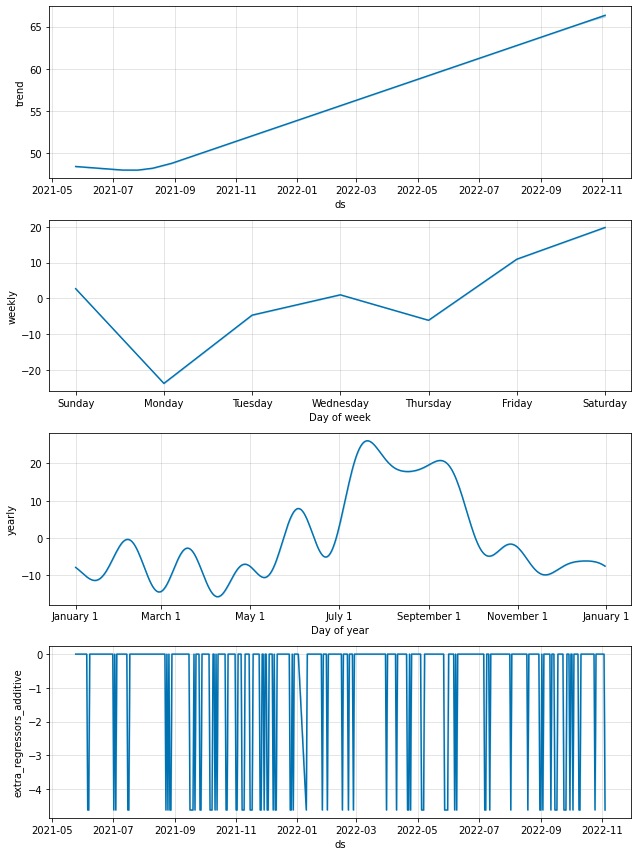

In [164]:
fig2_m = model_m.plot_components(forecast_m)

In [167]:
from prophet.diagnostics import cross_validation,performance_metrics

cv_results = cross_validation(model = model_m,horizon = "120 days",
                         period = "10 days",
                         initial = "350 days")
df_p = performance_metrics(cv_results)
df_p
     

INFO:prophet:Making 3 forecasts with cutoffs between 2022-05-18 00:00:00 and 2022-06-07 00:00:00


  0%|          | 0/3 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdm8b6npc/s6jnoqyl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdm8b6npc/jkkx2uxw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49646', 'data', 'file=/tmp/tmpdm8b6npc/s6jnoqyl.json', 'init=/tmp/tmpdm8b6npc/jkkx2uxw.json', 'output', 'file=/tmp/tmpdm8b6npc/prophet_modelr5ptzz2k/prophet_model-20221213120903.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:09:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:09:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdm8b6npc/343qvy_n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdm8b6npc/crk_l57m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,12 days,244.110747,15.624044,12.970947,0.297392,0.205734,0.247822,0.911765
1,13 days,269.378565,16.412756,13.704053,0.317546,0.257688,0.261436,0.882353
2,14 days,255.610982,15.987839,13.487162,0.303796,0.257688,0.253093,0.901961
3,15 days,258.093677,16.065294,13.727588,0.309342,0.257688,0.259029,0.911765
4,16 days,263.781754,16.241359,13.863520,0.312695,0.285806,0.261341,0.911765
...,...,...,...,...,...,...,...,...
104,116 days,697.095944,26.402575,22.023986,0.384724,0.260939,0.323193,0.666667
105,117 days,733.994192,27.092327,22.736735,0.435480,0.286855,0.347701,0.647059
106,118 days,785.865436,28.033292,24.115545,0.482878,0.294869,0.376245,0.617647
107,119 days,783.759863,27.995712,24.095778,0.492565,0.294869,0.380695,0.607843


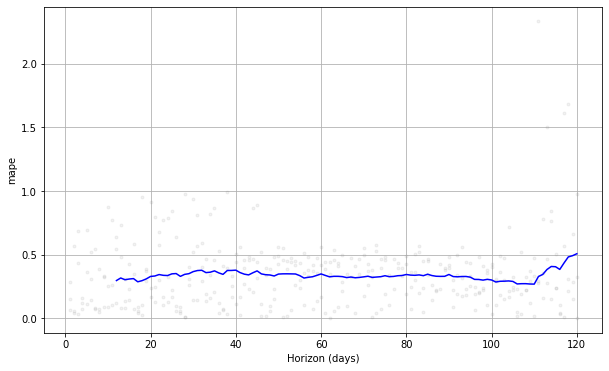

In [168]:
from prophet.plot import plot_cross_validation_metric

fig3 = plot_cross_validation_metric(cv_results,metric='mape')

In [169]:
df_p.mean()

horizon     66 days 00:00:00
mse              1113.405119
rmse               32.330032
mae                26.789195
mape                0.338437
mdape               0.318269
smape               0.360917
coverage             0.57182
dtype: object

In [170]:
# GridSearch
import itertools

param_grid = { 'changepoint_prior_scale':[0.001, 0.01, 0.1, 0.05],
              'seasonality_prior_scale':[0.01, 0.1, 1.0, 10.0], }

# Genero tutte le combinazioni dei parametri
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
mape = []  # Store the RMSEs for each params here

In [171]:
for params in all_params:
    model = Prophet(**params).fit(data_new)  # Fit model with given params
    df_cv = cross_validation(model, 
                             horizon="120 days",
                             period='10 days', #shift - moving windows
                             initial='350 days', 
                             )
    
    df_p = performance_metrics(cv_results, rolling_window=1)
    mape.append(df_p['mape'].values[0])

tuning_results = pd.DataFrame(all_params)
tuning_results['mape'] = mape
print(tuning_results)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdm8b6npc/ks_9dnwh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdm8b6npc/dm5x4f2h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13836', 'data', 'file=/tmp/tmpdm8b6npc/ks_9dnwh.json', 'init=/tmp/tmpdm8b6npc/dm5x4f2h.json', 'output', 'file=/tmp/tmpdm8b6npc/prophet_modeloen0g04z/prophet_model-20221213121601.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:16:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:16:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 6 forecasts with cuto

  0%|          | 0/6 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdm8b6npc/bcocjffq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdm8b6npc/2fr6yt3p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42803', 'data', 'file=/tmp/tmpdm8b6npc/bcocjffq.json', 'init=/tmp/tmpdm8b6npc/2fr6yt3p.json', 'output', 'file=/tmp/tmpdm8b6npc/prophet_modelq5rrg5lv/prophet_model-20221213121601.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:16:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:16:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdm8b6npc/alqpms24.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdm8b6npc/2udgzhzv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

  0%|          | 0/6 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdm8b6npc/t2gq4020.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdm8b6npc/c8eosaub.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73351', 'data', 'file=/tmp/tmpdm8b6npc/t2gq4020.json', 'init=/tmp/tmpdm8b6npc/c8eosaub.json', 'output', 'file=/tmp/tmpdm8b6npc/prophet_modelzp06yjqz/prophet_model-20221213121608.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:16:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:16:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdm8b6npc/7dy_oalu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdm8b6npc/f4w64dpn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

  0%|          | 0/6 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdm8b6npc/dmqbu7az.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdm8b6npc/acgjacq8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72409', 'data', 'file=/tmp/tmpdm8b6npc/dmqbu7az.json', 'init=/tmp/tmpdm8b6npc/acgjacq8.json', 'output', 'file=/tmp/tmpdm8b6npc/prophet_modelgv9mb5rr/prophet_model-20221213121614.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:16:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:16:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdm8b6npc/oit3d8h6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdm8b6npc/7c11x5_2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

  0%|          | 0/6 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdm8b6npc/jfwycufd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdm8b6npc/mu9yyabz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50590', 'data', 'file=/tmp/tmpdm8b6npc/jfwycufd.json', 'init=/tmp/tmpdm8b6npc/mu9yyabz.json', 'output', 'file=/tmp/tmpdm8b6npc/prophet_modelvko4656v/prophet_model-20221213121620.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:16:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:16:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdm8b6npc/bh88hcoq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdm8b6npc/ejk2h3tx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

  0%|          | 0/6 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdm8b6npc/yyoc440v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdm8b6npc/e7srofs2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71877', 'data', 'file=/tmp/tmpdm8b6npc/yyoc440v.json', 'init=/tmp/tmpdm8b6npc/e7srofs2.json', 'output', 'file=/tmp/tmpdm8b6npc/prophet_modelyjt_1d9o/prophet_model-20221213121626.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:16:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:16:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdm8b6npc/3nq3tck5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdm8b6npc/rcl9cn0x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

  0%|          | 0/6 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdm8b6npc/pu9k3lyf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdm8b6npc/a1ry16eg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66749', 'data', 'file=/tmp/tmpdm8b6npc/pu9k3lyf.json', 'init=/tmp/tmpdm8b6npc/a1ry16eg.json', 'output', 'file=/tmp/tmpdm8b6npc/prophet_modelh280ysw7/prophet_model-20221213121631.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:16:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:16:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdm8b6npc/wswvw73_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdm8b6npc/5f4vrxlj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

  0%|          | 0/6 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdm8b6npc/vz6zdjs6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdm8b6npc/ingtfqtm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81714', 'data', 'file=/tmp/tmpdm8b6npc/vz6zdjs6.json', 'init=/tmp/tmpdm8b6npc/ingtfqtm.json', 'output', 'file=/tmp/tmpdm8b6npc/prophet_modeln0v39lib/prophet_model-20221213121636.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:16:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:16:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdm8b6npc/q3280hfy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdm8b6npc/6hkxwyz6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

  0%|          | 0/6 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdm8b6npc/4yl475za.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdm8b6npc/76du6aue.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65482', 'data', 'file=/tmp/tmpdm8b6npc/4yl475za.json', 'init=/tmp/tmpdm8b6npc/76du6aue.json', 'output', 'file=/tmp/tmpdm8b6npc/prophet_modelvlg1tx_b/prophet_model-20221213121641.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:16:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:16:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdm8b6npc/qe7nz0ri.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdm8b6npc/qflo2fjy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

  0%|          | 0/6 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdm8b6npc/ozh6h09c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdm8b6npc/g17fwb5g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74596', 'data', 'file=/tmp/tmpdm8b6npc/ozh6h09c.json', 'init=/tmp/tmpdm8b6npc/g17fwb5g.json', 'output', 'file=/tmp/tmpdm8b6npc/prophet_modelj39ncc5x/prophet_model-20221213121646.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:16:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:16:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdm8b6npc/bj0937hj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdm8b6npc/n3svoe75.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

  0%|          | 0/6 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdm8b6npc/j1mhls8f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdm8b6npc/8_rwibma.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=628', 'data', 'file=/tmp/tmpdm8b6npc/j1mhls8f.json', 'init=/tmp/tmpdm8b6npc/8_rwibma.json', 'output', 'file=/tmp/tmpdm8b6npc/prophet_modelpww1fr5y/prophet_model-20221213121651.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:16:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:16:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdm8b6npc/pqzqvgax.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdm8b6npc/8n9gf1n4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib

  0%|          | 0/6 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdm8b6npc/qtr4p1xw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdm8b6npc/o2gukjzu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4376', 'data', 'file=/tmp/tmpdm8b6npc/qtr4p1xw.json', 'init=/tmp/tmpdm8b6npc/o2gukjzu.json', 'output', 'file=/tmp/tmpdm8b6npc/prophet_model02anh2jt/prophet_model-20221213121656.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:16:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:16:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdm8b6npc/wzkh8h2e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdm8b6npc/r3embh8g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/li

  0%|          | 0/6 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdm8b6npc/8s0wyjec.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdm8b6npc/cz6l0gs4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23126', 'data', 'file=/tmp/tmpdm8b6npc/8s0wyjec.json', 'init=/tmp/tmpdm8b6npc/cz6l0gs4.json', 'output', 'file=/tmp/tmpdm8b6npc/prophet_modelggrjjuvn/prophet_model-20221213121701.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:17:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:17:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdm8b6npc/u4bqnkj2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdm8b6npc/8io7x1ow.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

  0%|          | 0/6 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdm8b6npc/oymmmdev.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdm8b6npc/1zdb8i35.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85438', 'data', 'file=/tmp/tmpdm8b6npc/oymmmdev.json', 'init=/tmp/tmpdm8b6npc/1zdb8i35.json', 'output', 'file=/tmp/tmpdm8b6npc/prophet_modelpylosdhb/prophet_model-20221213121706.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:17:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:17:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdm8b6npc/51_zkbym.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdm8b6npc/p2rclt2n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

  0%|          | 0/6 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdm8b6npc/z9b8hpwi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdm8b6npc/7p8wrvbf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26326', 'data', 'file=/tmp/tmpdm8b6npc/z9b8hpwi.json', 'init=/tmp/tmpdm8b6npc/7p8wrvbf.json', 'output', 'file=/tmp/tmpdm8b6npc/prophet_model1n6y18vf/prophet_model-20221213121711.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:17:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:17:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdm8b6npc/slcsbyvx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdm8b6npc/fyj3q_a4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

  0%|          | 0/6 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdm8b6npc/vauyvvm0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdm8b6npc/71wbdbdk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46578', 'data', 'file=/tmp/tmpdm8b6npc/vauyvvm0.json', 'init=/tmp/tmpdm8b6npc/71wbdbdk.json', 'output', 'file=/tmp/tmpdm8b6npc/prophet_model1bgd45mn/prophet_model-20221213121716.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:17:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:17:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdm8b6npc/0azzd_pt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdm8b6npc/m1cbvkow.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

  0%|          | 0/6 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdm8b6npc/ulwbq5or.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdm8b6npc/sono4m11.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53372', 'data', 'file=/tmp/tmpdm8b6npc/ulwbq5or.json', 'init=/tmp/tmpdm8b6npc/sono4m11.json', 'output', 'file=/tmp/tmpdm8b6npc/prophet_model_ynr5yi5/prophet_model-20221213121721.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:17:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:17:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdm8b6npc/ubqxwhmy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdm8b6npc/hichr0_u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

    changepoint_prior_scale  seasonality_prior_scale      mape
0                     0.001                     0.01  0.341574
1                     0.001                     0.10  0.341574
2                     0.001                     1.00  0.341574
3                     0.001                    10.00  0.341574
4                     0.010                     0.01  0.341574
5                     0.010                     0.10  0.341574
6                     0.010                     1.00  0.341574
7                     0.010                    10.00  0.341574
8                     0.100                     0.01  0.341574
9                     0.100                     0.10  0.341574
10                    0.100                     1.00  0.341574
11                    0.100                    10.00  0.341574
12                    0.050                     0.01  0.341574
13                    0.050                     0.10  0.341574
14                    0.050                     1.00  0

In [172]:
best_params = all_params[np.argmin(mape)]
print(best_params)

{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01}


In [173]:
model_tuned_m = Prophet(changepoint_prior_scale= 0.001,
                      seasonality_prior_scale= 0.01,
                      seasonality_mode = 'additive',
                      interval_width = 0.95,
                      daily_seasonality  = False,
                      weekly_seasonality = True,
                      yearly_seasonality = False,
                     )
model_tuned_m.fit(data_new)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdm8b6npc/b9ib3x9a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdm8b6npc/ecsfou2w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17090', 'data', 'file=/tmp/tmpdm8b6npc/b9ib3x9a.json', 'init=/tmp/tmpdm8b6npc/ecsfou2w.json', 'output', 'file=/tmp/tmpdm8b6npc/prophet_modelynmmux7i/prophet_model-20221213121806.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:18:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:18:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [174]:
df_cv_final_m = cross_validation(model_tuned_m,
                         horizon = "120 days",
                         period = "10 days",
                         initial = "350 days")

INFO:prophet:Making 6 forecasts with cutoffs between 2022-05-19 00:00:00 and 2022-07-08 00:00:00


  0%|          | 0/6 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdm8b6npc/m7daxlu_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdm8b6npc/t40mgzbp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40999', 'data', 'file=/tmp/tmpdm8b6npc/m7daxlu_.json', 'init=/tmp/tmpdm8b6npc/t40mgzbp.json', 'output', 'file=/tmp/tmpdm8b6npc/prophet_modelljg44n36/prophet_model-20221213121810.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:18:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:18:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdm8b6npc/209lg4b6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdm8b6npc/p9x29lq2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

In [176]:
performance_metrics(df_cv_final_m).mean()

horizon     66 days 00:00:00
mse              2087.532997
rmse               45.140443
mae                37.318528
mape                0.433735
mdape               0.454978
smape               0.547433
coverage            0.507127
dtype: object

# XG BOOST

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [ ]:
data

,Quantita,Tipologia
Calendario,,
2021-05-05,2.00,Spine
2021-05-21,3.25,Spine
2021-05-25,228.00,Spine
2021-05-26,181.80,Spine
2021-05-27,256.00,Spine
...,...,...
2022-11-05,128.18,Cocktail
2022-11-19,58.12,Cocktail
2022-11-20,16.00,Cocktail


In [ ]:
data_burger = data[data['Tipologia'] == 'Burger']
data_burger = data_burger[(data_burger.index >= '2021-05-25') & (data_burger.index <= '2022-11-05')]

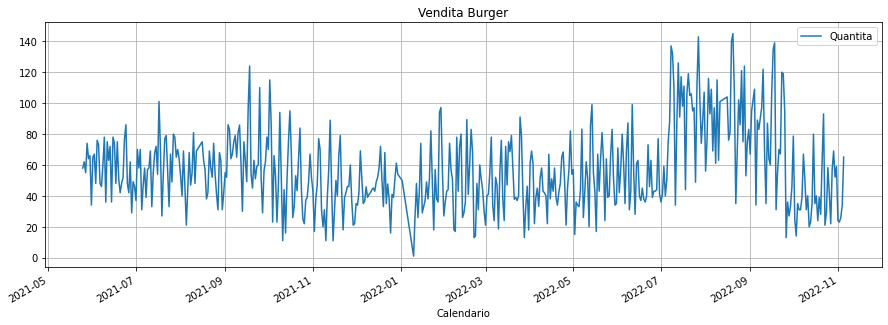

In [ ]:
data_burger.plot(style='-',
        figsize=(15, 5),
        #color=color_pal[0],
        title='Vendita Burger')
plt.grid()
plt.show()

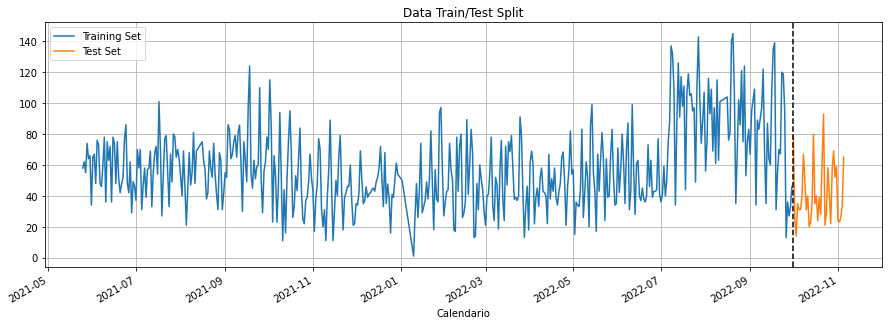

In [ ]:
# Divido in train e test
train = data_burger.loc[data_burger.index < '2022-10-01']
test = data_burger.loc[data_burger.index >= '2022-10-01']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('2022-10-01', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.grid()
plt.show()

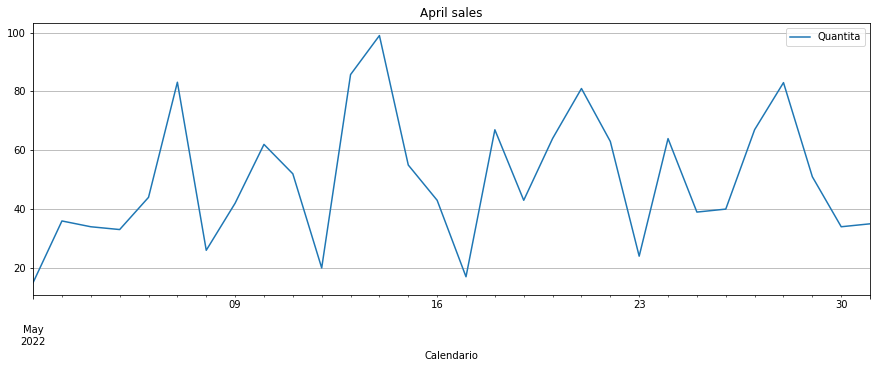

In [ ]:
data_burger.loc[(data_burger.index > '2022-05-01') & (data_burger.index < '2022-06-01')] \
    .plot(figsize=(15, 5), title='April sales')

plt.grid()
plt.show()

In [ ]:
# Creo feature
def create_features(data):
    """
    Create time series features based on time series index.
    """
    data = data.copy()
    #data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    data['quarter'] = data.index.quarter
    data['month'] = data.index.month
    data['year'] = data.index.year
    data['dayofyear'] = data.index.dayofyear
    data['dayofmonth'] = data.index.day
    data['weekofyear'] = data.index.isocalendar().week
    return data

data_burger = create_features(data_burger)

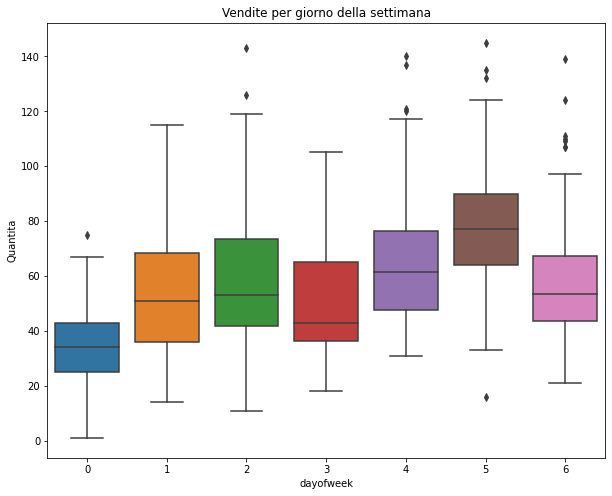

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=data_burger, x='dayofweek', y='Quantita')
ax.set_title('Vendite per giorno della settimana')
plt.show()


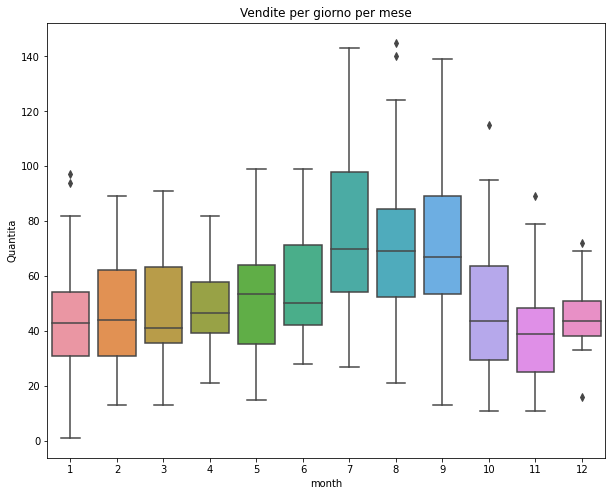

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=data_burger, x='month', y='Quantita')
ax.set_title('Vendite per giorno per mese')
plt.show()

In [ ]:
# Creo modello XGBoost
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'Quantita'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [ ]:
model = xgb.XGBRegressor(base_score=0.5, 
                       booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01
                       )
model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:62.607	validation_1-rmse:44.8192
[100]	validation_0-rmse:28.7906	validation_1-rmse:17.2037
[200]	validation_0-rmse:18.684	validation_1-rmse:23.7812
[300]	validation_0-rmse:16.0025	validation_1-rmse:26.4593
[400]	validation_0-rmse:15.1681	validation_1-rmse:25.8904
[500]	validation_0-rmse:14.5989	validation_1-rmse:25.3669
[600]	validation_0-rmse:14.2668	validation_1-rmse:25.5107
[700]	validation_0-rmse:13.9449	validation_1-rmse:25.5979
[800]	validation_0-rmse:13.6116	validation_1-rmse:25.6963
[900]	validation_0-rmse:13.3269	validation_1-rmse:25.8292
[999]	validation_0-rmse:13.094	validation_1-rmse:26.0428


XGBRegressor(early_stopping_rounds=50, learning_rate=0.01, n_estimators=1000,
             objective='reg:squarederror')

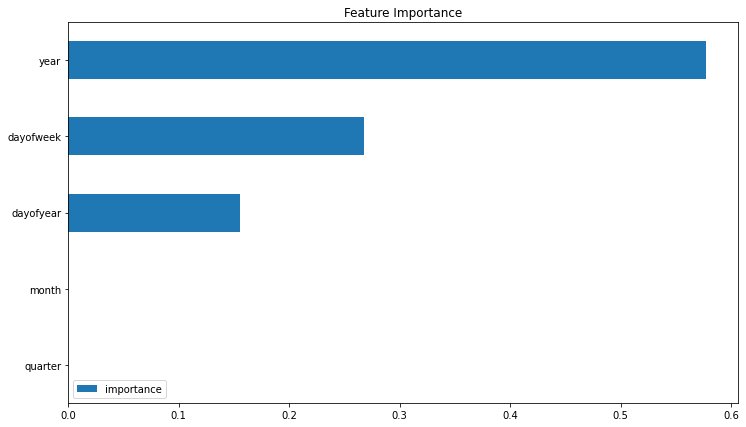

In [ ]:
# Importanza feature
feature_important = model.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(model.feature_importances_)

fi = pd.DataFrame(data=values, index=FEATURES, columns=["importance"])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance',figsize=(12,7));

In [ ]:
print(values)
print(keys)

[0.15548234, 0.2674666, 0.0, 0.0, 0.57705104]
['dayofweek', 'dayofyear', 'year']


In [ ]:
test

,Quantita,Tipologia,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Calendario,,,,,,,,,
2022-10-01,78.64,Burger,5,4,10,2022,274,1,39
2022-10-02,25.00,Burger,6,4,10,2022,275,2,39
2022-10-03,14.00,Burger,0,4,10,2022,276,3,40
2022-10-04,34.99,Burger,1,4,10,2022,277,4,40
2022-10-05,31.00,Burger,2,4,10,2022,278,5,40
2022-10-06,31.00,Burger,3,4,10,2022,279,6,40
2022-10-07,39.00,Burger,4,4,10,2022,280,7,40
2022-10-08,66.94,Burger,5,4,10,2022,281,8,40
2022-10-09,51.00,Burger,6,4,10,2022,282,9,40


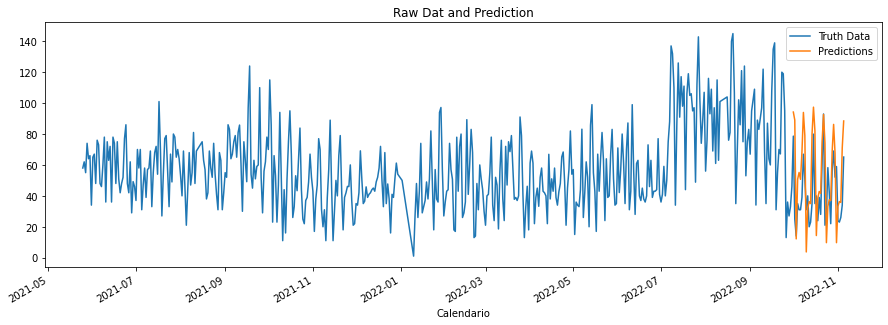

In [ ]:
# Forecast on test
test['prediction'] = model.predict(X_test)
df = data_burger.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = data_burger[['Quantita']].plot(figsize=(15, 5))

df['prediction'].plot(ax=ax, style='-')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()


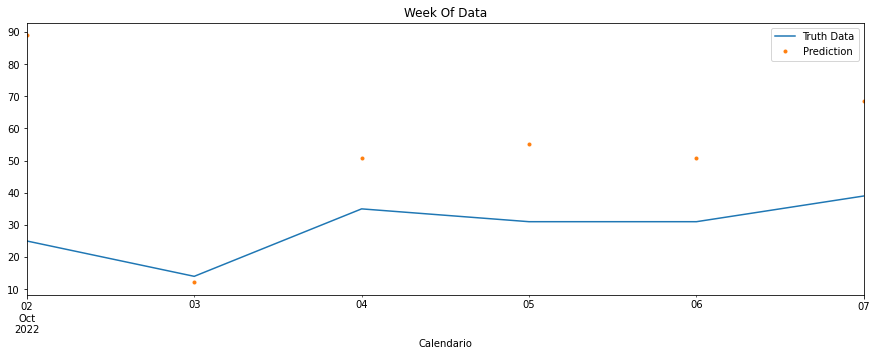

In [ ]:
ax = df.loc[(df.index > '2022-10-01') & (df.index < '2022-10-08')]['Quantita'] \
    .plot(figsize=(15, 5), title='Week Of Data')

df.loc[(df.index > '2022-10-01') & (df.index < '2022-10-08')]['prediction'] \
    .plot(style='.')

plt.legend(['Truth Data','Prediction'])
plt.show()

## Indici di errore

In [ ]:
# Score (RMSE+MAPE)
from sklearn.metrics import mean_absolute_percentage_error

rmse = np.sqrt(mean_squared_error(test['Quantita'], test['prediction']))
print(f"RMSE Score on Test set: {rmse:0.2f}")

mape = mean_absolute_percentage_error(test['Quantita'], test['prediction'])
print(f"MAPE Score on Test set: {mape:0.2f}")

RMSE Score on Test set: 26.04
MAPE Score on Test set: 0.63


In [ ]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2022-10-02    70.445641
2022-09-28    64.012505
2022-10-23    62.495644
2022-09-29    56.956302
2022-10-05    56.552223
2022-10-14    56.503098
2022-09-30    55.260612
2022-10-16    51.482132
2022-11-04    51.039780
2022-10-12    49.315773
Name: error, dtype: float64

In [ ]:
#TIME SERIES CROSS VALIDATION SPLIT
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=1*30*1, gap=1)
df = df.sort_index()


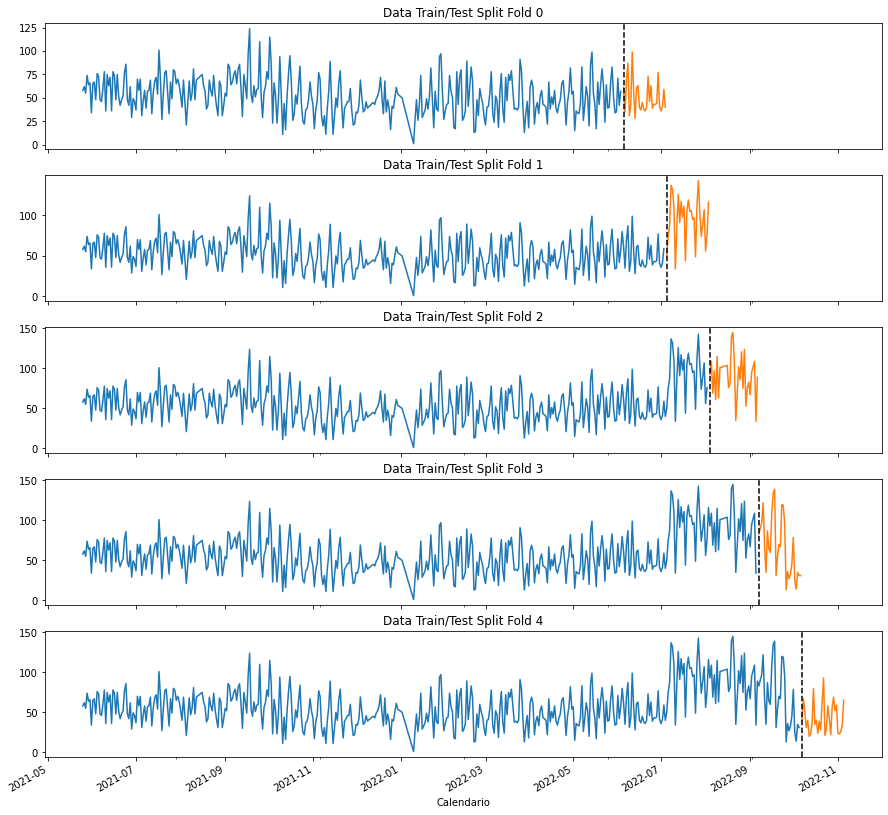

In [ ]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['Quantita'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['Quantita'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [ ]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    #df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)


In [ ]:
def add_lags(df):
    target_map = df['Quantita'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('30 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('60 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('90 days')).map(target_map)
    return df


In [ ]:
df = add_lags(df)
df

,Quantita,Tipologia,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,prediction,lag1,lag2,lag3
Calendario,,,,,,,,,,,,,
2021-05-25,58.00,Burger,1,2,5,2021,145,25,21,NaN,NaN,NaN,NaN
2021-05-26,62.00,Burger,2,2,5,2021,146,26,21,NaN,NaN,NaN,NaN
2021-05-27,55.00,Burger,3,2,5,2021,147,27,21,NaN,NaN,NaN,NaN
2021-05-28,74.00,Burger,4,2,5,2021,148,28,21,NaN,NaN,NaN,NaN
2021-05-29,64.00,Burger,5,2,5,2021,149,29,21,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-01,23.98,Burger,1,4,11,2022,305,1,44,33.204914,25.00,94.98,116.00
2022-11-02,23.00,Burger,2,4,11,2022,306,2,44,36.313622,14.00,101.98,93.08
2022-11-03,26.00,Burger,3,4,11,2022,307,3,44,35.738945,34.99,109.00,109.00


## Cross Validation

In [ ]:
tss = TimeSeriesSplit(n_splits=5, test_size=1*30*1, gap=1)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'Quantita'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    model = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:squarederror',
                           max_depth=3,
                           learning_rate=0.01)
    model.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = model.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:54.6691	validation_1-rmse:52.3243
[100]	validation_0-rmse:24.6131	validation_1-rmse:23.5886
[200]	validation_0-rmse:15.6459	validation_1-rmse:17.7646
[300]	validation_0-rmse:13.3407	validation_1-rmse:17.9681
[400]	validation_0-rmse:12.6815	validation_1-rmse:18.2215
[500]	validation_0-rmse:12.2991	validation_1-rmse:18.3807
[600]	validation_0-rmse:11.9495	validation_1-rmse:18.4363
[700]	validation_0-rmse:11.6087	validation_1-rmse:18.461
[800]	validation_0-rmse:11.2733	validation_1-rmse:18.4688
[900]	validation_0-rmse:10.9699	validation_1-rmse:18.4339
[999]	validation_0-rmse:10.6798	validation_1-rmse:18.4049
[0]	validation_0-rmse:54.6054	validation_1-rmse:97.933
[100]	validation_0-rmse:24.682	validation_1-rmse:65.3562
[200]	validation_0-rmse:15.8875	validation_1-rmse:54.4726
[300]	validation_0-rmse:13.6497	validation_1-rmse:50.3347
[400]	validation_0-rmse:12.956	validation_1-rmse:48.7195
[500]	validation_0-rmse:12.408	validation_1-rmse:48.088
[600]	validation_0-rmse:

In [ ]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 29.6082
Fold scores:[18.404871793555035, 46.80874388154982, 30.364711147103247, 32.68262302360428, 19.78012164106751]


In [ ]:
# Retrain on all data
df = create_features(df)

FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = 'Quantita'

X_all = df[FEATURES]
y_all = df[TARGET]

model = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
model.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[17:41:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:61.5561
[100]	validation_0-rmse:28.7992
[200]	validation_0-rmse:18.8897
[300]	validation_0-rmse:16.0255
[400]	validation_0-rmse:15.0267
[499]	validation_0-rmse:14.5063


XGBRegressor(learning_rate=0.01, n_estimators=500)

In [ ]:
df.index.max()

Timestamp('2022-11-05 00:00:00')

In [ ]:
# Create future dataframe
future = pd.date_range('2022-11-05','2022-12-05', freq='1d')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [ ]:
future_w_features = df_and_future.query('isFuture').copy()

In [ ]:
# Predirre il futuro
FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year','lag1','lag2','lag3']
future_w_features[FEATURES]

,dayofyear,dayofweek,quarter,month,year,lag1,lag2,lag3
2022-11-05,309,5,4,11,2022,31.00,89.00,97.00
2022-11-06,310,6,4,11,2022,39.00,83.00,60.97
2022-11-07,311,0,4,11,2022,66.94,90.07,115.00
2022-11-08,312,1,4,11,2022,51.00,96.97,63.00
2022-11-09,313,2,4,11,2022,31.00,121.97,101.00
2022-11-10,314,3,4,11,2022,40.00,68.00,NaN
2022-11-11,315,4,4,11,2022,20.00,34.99,NaN
2022-11-12,316,5,4,11,2022,23.00,87.00,NaN
2022-11-13,317,6,4,11,2022,35.00,64.00,NaN
2022-11-14,318,0,4,11,2022,79.91,60.00,104.00


In [ ]:
future_w_features['pred'] = model.predict(future_w_features[FEATURES])
future_w_features['pred']


2022-11-05    63.694542
2022-11-06    51.394875
2022-11-07    23.858932
2022-11-08    35.209579
2022-11-09    33.239174
2022-11-10    37.948780
2022-11-11    53.438354
2022-11-12    64.493210
2022-11-13    52.495789
2022-11-14    29.037487
2022-11-15    33.469116
2022-11-16    34.228436
2022-11-17    33.264904
2022-11-18    53.158314
2022-11-19    61.372616
2022-11-20    54.042126
2022-11-21    28.178816
2022-11-22    33.469116
2022-11-23    34.187199
2022-11-24    32.339058
2022-11-25    45.140942
2022-11-26    56.610870
2022-11-27    46.784775
2022-11-28    31.005304
2022-11-29    37.624458
2022-11-30    40.468830
2022-12-01    38.415379
2022-12-02    45.099705
2022-12-03    56.610870
2022-12-04    49.243687
2022-12-05    28.301485
Name: pred, dtype: float32

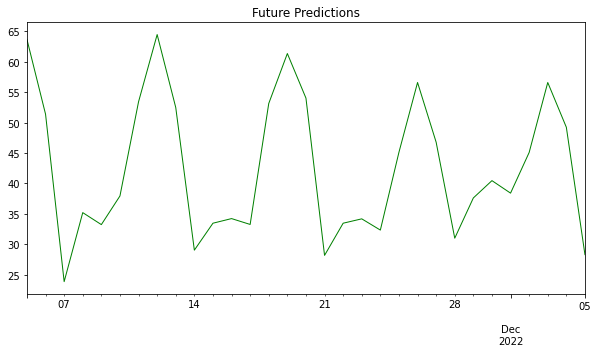

In [ ]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color='green',
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()